## Facial recognition using different methods
* The Main purpose of this project is to basically try different approaches to solve the facial recognition problem and see what method works best to classify our model IU correctly
* Our approaches will focus on using Deep Learning as the main method but we will try different model structures and optimization algorithms to better solve our problem

## Data preparation
### images of people:
1. CelebA
2. Google Images
3. Videos

> The images in our dataset must all be aligned.
> Meaning that the faces need to be centered and cropped accordingly

> 2 Different datasets that both originate from the same dataset will be used to train our models
> For the models that implement triplet use, a MTCNN aligned dataset will be used, and all input will be MTCNN aligned.
> For the normal image classification networks, artificially augmented image data will be used as input.


### Input format:
128 X 128 RGB image

### Output format:
0~1 value 0 being not IU 1 being IU

## Locate faces in images

Processing: , Number of faces found: 1


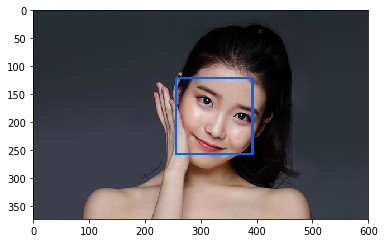

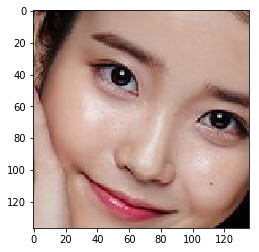

In [2]:
from data_prep.image_pipeline import ImageDisplayer, display_image_array
%matplotlib inline

ImageDisplayer("examples/2.jpg")

## Rotate align, and cut faces in images

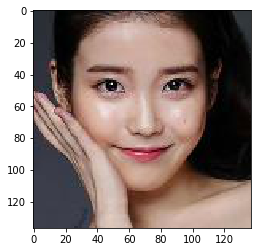

In [2]:
from PIL import Image
import numpy as np

aligned_image = Image.open("examples/output.jpg")
display_image_array(aligned_image)

## Augment images before feeding them in as input

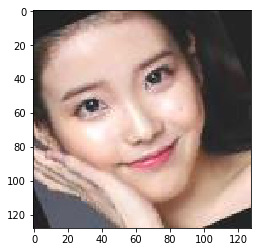

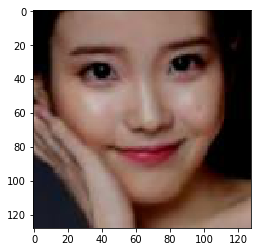

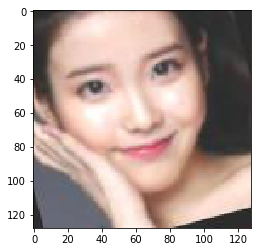

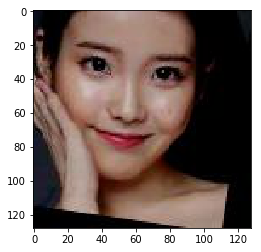

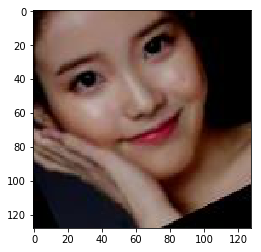

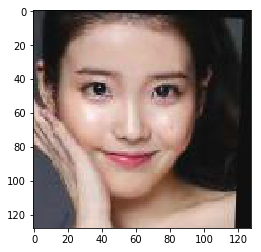

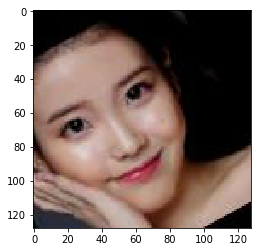

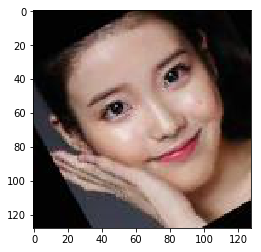

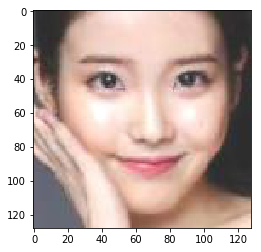

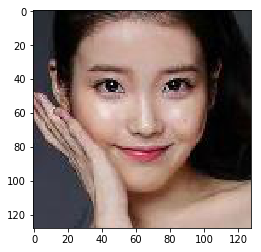

In [5]:
import os

augmented_path = os.path.join("examples", "augmented")
images = os.listdir(augmented_path)
for im in images:
    full_path = os.path.join(augmented_path, im)
    augmented_image = Image.open(full_path)
    display_image_array(augmented_image)

### Image pipeline summary
1. Get the original source image(Google images, videos and CelebA for negative samples)
2. Locate the face bounding boxes and landmarks
3. Filter out images that have too low quality
3. Rotate and scale to correctly align faces based on face landmarks
4. Make 9 different augmented versions of the image focused on augmenting, lighting, rotation, blur and scale (10 images in total per image including the original) ** This step is meant to mimic real life photos **
5. Feed into network

** The augmented dataset is 10 times larger than the original filtered dataset. **  
** Images are resized to (128, 128) before being fed into network. **  
(Images of faces that do not fit the min image size are filtered out before)

Processing: 1.jpg, Number of faces found: 2


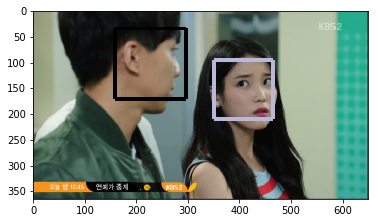

Processing: 2.jpg, Number of faces found: 1


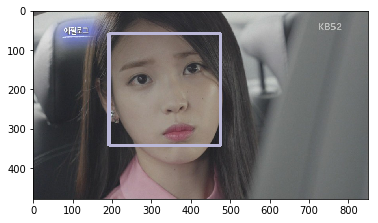

Processing: 3.jpg, Number of faces found: 1


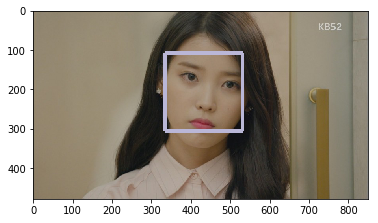

Processing: 4.jpg, Number of faces found: 1


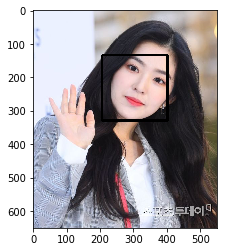

Processing: 5.jpg, Number of faces found: 2


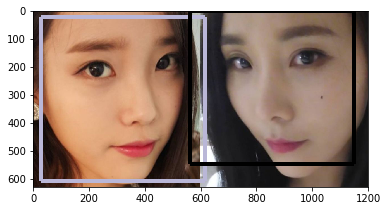

[True, False]

In [3]:
from test import test_model_individual
from cnn_models.hotdog import DeepDog

model = DeepDog(summarize=False)
model.load_model()

test_model_individual(model, "examples/test/1.jpg")
test_model_individual(model, "examples/test/2.jpg")
test_model_individual(model, "examples/test/3.jpg")
test_model_individual(model, "examples/test/4.jpg")
test_model_individual(model, "examples/test/5.jpg")

### 1. Transfer Learning


### 2. Convolutional Neural Network

### 3. Convolutional Neural Network - 2

```python
from keras.applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, \
    GlobalAveragePooling2D, Dense, BatchNormalization, Activation
from keras.models import Model
from keras.engine.topology import get_source_inputs
from depthwise_conv2d import DepthwiseConvolution2D

'''Google MobileNet model for Keras.
# Reference:
- [MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications](https://arxiv.org/pdf/1704.04861.pdf)
'''

def MobileNet(input_tensor=None, input_shape=None, alpha=1, shallow=False, classes=1000):
    """Instantiates the MobileNet.Network has two hyper-parameters
        which are the width of network (controlled by alpha)
        and input size.
        
        # Arguments
            input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
                to use as image input for the model.
            input_shape: optional shape tuple, only to be specified
                if `include_top` is False (otherwise the input shape
                has to be `(224, 224, 3)` (with `channels_last` data format)
                or `(3, 224, 244)` (with `channels_first` data format).
                It should have exactly 3 inputs channels,
                and width and height should be no smaller than 96.
                E.g. `(200, 200, 3)` would be one valid value.
            alpha: optional parameter of the network to change the 
                width of model.
            shallow: optional parameter for making network smaller.
            classes: optional number of classes to classify images
                into.
        # Returns
            A Keras model instance.

        """

    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=96,
                                      data_format=K.image_data_format(),
                                      include_top=True)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = Convolution2D(int(32 * alpha), (3, 3), strides=(2, 2), padding='same', use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = DepthwiseConvolution2D(int(32 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(int(64 * alpha), (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = DepthwiseConvolution2D(int(64 * alpha), (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(int(128 * alpha), (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = DepthwiseConvolution2D(int(128 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(int(128 * alpha), (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = DepthwiseConvolution2D(int(128 * alpha), (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(int(256 * alpha), (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = DepthwiseConvolution2D(int(256 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(int(256 * alpha), (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = DepthwiseConvolution2D(int(256 * alpha), (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(int(512 * alpha), (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    if not shallow:
        for _ in range(5):
            x = DepthwiseConvolution2D(int(512 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Convolution2D(int(512 * alpha), (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

    x = DepthwiseConvolution2D(int(512 * alpha), (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(int(1024 * alpha), (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = DepthwiseConvolution2D(int(1024 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(int(1024 * alpha), (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = GlobalAveragePooling2D()(x)
    out = Dense(classes, activation='softmax')(x)

    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, out, name='mobilenet')

    return model


if __name__ == '__main__':
    m = MobileNet()
    print "model ready"
```    

## 4. VGG-Face

* https://github.com/serengil/tensorflow-101/blob/master/python/vgg-face.ipynb
* Take use of vector similarity to identify a person